# Agenda

In this tutorial we are going to see how do I use the **scikit library** to measure the accuracy of classification methods based on:

- 1. Confusion matrix
- 2. ROC curve
- 3. Area Under the Curve (AUC)

## Upload the data and create the variables of interest

Import the original mortgage data which are contained in the "Default.csv" file. The data are imported by using the **pandas liibrary** via the usual command *import pandas as pd* 

In [1]:
import pandas as pd

df = pd.read_csv(r'Default.csv', index_col=0)
df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462905
50%,823.636973,34552.644800
75%,1166.308387,43807.729275
max,2654.322576,73554.233500


The variable we want to predict here is the *default*. In particular, we want to predict how many times a credit card loan is defaulted based on a large set of individuals in the US. The predictors are the *balance* of account and the *income*. We need first to transform the default variabe from categorical to numerical. 

This can be done in a variety of alternative ways. The one we use here is simply set of a dummy equal to one for when default = YES and zero otherwise. 

In [2]:
import numpy as np

df['default_dummy'] = np.where(df['default'].str.contains('Yes'), 1, 0)

We see that we created a set of dummy variables which coincides with the different categories of the loans. We are interested in the "default_Yes" category, so this dummy variable is going to be our target object we need to predict. 

As predictors we use a set of mortgage characteristics which are in the dataset, such as:

- Balance of account (balance)
- Household income (income)

In order to make the estimates more numerically stable we *rescale* the predictors by divided each series by its standard deviation. To do that we use the command **StandardScaler** from the **sklearn** package. 

In [3]:
from sklearn.preprocessing import StandardScaler

X = df[['balance','income']]
X = StandardScaler(with_mean=True).fit_transform(X)
#with_mean=True: substract the mean of data
y = df['default_dummy']

Since we wish to predict the charged off mortgages out of sample, we need to split the sample of observations between those that will be used for training/validation and those which will be used for testing. This is done using the command *train_test_split*. 

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

Notice that since the variable of interest is highly imbalanced, meaning there is only a small fraction of defaulted mortgages compared to the total amount of observations, we need to "stratify" the splitting, meaning we need to split between training/validation and testing in a way that keeps the proportion of default vs non-default comparable between the sample that is used for training and validation and the sample that is used for testing. 

## Forecast the probability of default using the testing observations

### Logistic regression 

We can estimate our binary logistic regression by using the training/validation dataset and make predictions based on the predictors available for the testing sample

In [5]:
from sklearn.linear_model import LogisticRegression
#c defines the regulation we will apply, the smaller the value of c the greater the regulation applied
#max_iter refers to the maxium iterations allowed for the optimiser to reach a solution
model = LogisticRegression(C=1e6, max_iter=1e5)
model.fit(X_train, y_train)
yhat  = model.predict(X_test)

Let now measure the forecasting accuracy of the model. We can look at the confusion matrix first.

In [6]:
from sklearn import metrics

print(metrics.confusion_matrix(y_test, yhat))

[[4820   14]
 [ 111   55]]


The model seems to perform reasonably well, meaning that the proportion of true positives and negatives is much larger than the fraction of false positives or negatives. 

In [7]:
# generate a no skill prediction (majority class)
# 0 values. number of 0s = elements in the 'y_test'
# use'_' in the for loop to avoid new variables and taking new space in the memory
ns_probs = [0 for _ in range(len(y_test))]

# generate the predicted probabilities from the logistic regression
# use 'predict_proba' to retrieve the calculated prob. of the logistic regression model we fitted
# to get the prob. we need to provide the x variables from the test sample
# we then keep all the rows from column 2
lr_probs = model.predict_proba(X_test)[:,1]

We can now compare our logistic regression against the "no-skill" model. 

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

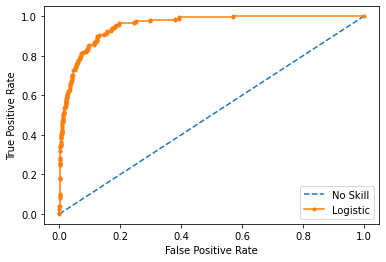

In [9]:
import matplotlib.pyplot as plt
# Visualisation with plot_metric

# call the roc curve for the test data using the logistic prob. and the random prob.
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

Clearly, the model seems to perform well. The ROC is reasonably close to one and is much more closer to the upper-left corner than a model with "no-skills". Let also compare the AUC score. 

In [10]:
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.954


There is a large difference between the two. Our Logistic regression model is much closer to the optimal AUC of 1 than the most naive classifier. 

### Classification tree 

We now estimate a classification tree with the maximum number of layers (**max_depth**) fixed at 6. 

In [11]:
from sklearn.tree import DecisionTreeClassifier
# decision tree with max depth of 6
dt = DecisionTreeClassifier(max_depth = 6)
dt.fit(X_train, y_train)

# get the predicted prob. of the test sample
y_dt_pred = dt.predict(X_test)

Let calculate the confusion matrix from the classification tree

In [13]:
print(metrics.confusion_matrix(y_test, yhat))

[[4820   14]
 [ 111   55]]


Let compare the performance from the classification tree against the naive (no-skill) classifier as well as the logistic regression 

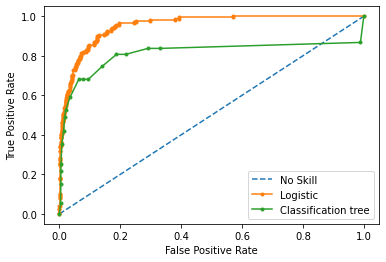

In [14]:
# generate the predicted probabilities from the logistic regression
dt_probs = dt.predict_proba(X_test)[:,1]

dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Classification tree')


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

Compare the AUC for the no-skill classifier, the logistic regression and the classification tree. 

In [15]:
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
dt_auc = roc_auc_score(y_test, dt_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('Tree: ROC AUC=%.3f' % (dt_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.954
Tree: ROC AUC=0.813


Comment the results. 